###Importing Stuff

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import dlib
import numpy as np
from skimage import feature
import cv2
import numpy as np
import pandas as pd
import os
from IPython.display import clear_output


In [3]:
import transformers
from transformers import ViTImageProcessor, TFViTForImageClassification,FlaxViTForImageClassification,ViTForImageClassification
import tensorflow as tf
from PIL import Image, ImageChops, ImageEnhance
import jax

###Testing the ViT for feature extraction

In [4]:
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [5]:
model = FlaxViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/346M [00:00<?, ?B/s]

Getting the features for 1 image

In [ ]:
inputs = feature_extractor(images=image, return_tensors="np")
outputs = model(**inputs,output_hidden_states=True)

features

In [ ]:
features=outputs.hidden_states[12]
features.shape

(1, 197, 768)

###Testing ELA and Mobilenet for feature extraction

In [ ]:
import cv2
import numpy as np

def ela(image, quality):
    # Save the original image with a specified quality
    temp_path = "temp.jpg"
    cv2.imwrite(temp_path, cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR), [cv2.IMWRITE_JPEG_QUALITY, quality])

    # Read the temporary image using OpenCV
    temp_image = cv2.imread(temp_path)

    # Calculate the absolute difference between the original and temporary images
    ela_image = cv2.absdiff(np.array(image), temp_image)

    #Convert the difference image to grayscale
    ela_image = cv2.cvtColor(ela_image, cv2.COLOR_BGR2GRAY)

    # Enhance the brightness of the ELA image
    ela_image = cv2.equalizeHist(ela_image)
    return Image.fromarray(ela_image, 'L')

In [ ]:
image=cv2.imread("/content/drive/MyDrive/Capstone/Images/val_small_15/Fake/samples_id28_id30_0001.mp4_face_16_0.jpg")

ela_result=ela(image,80)

In [ ]:
type(ela_result)

PIL.Image.Image

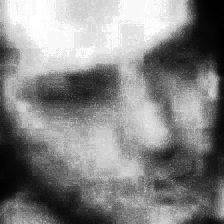

In [ ]:
ela_result

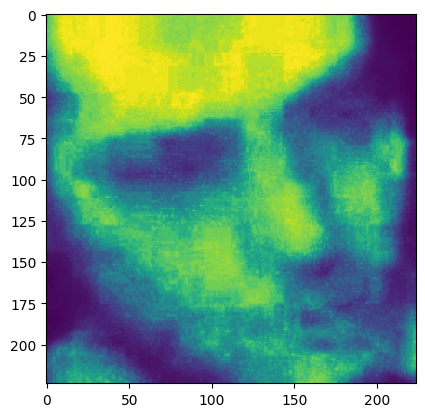

In [ ]:
plt.imshow(ela_result)

In [ ]:
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224,3))

In [ ]:
img_array=np.stack((ela_result,)*3,axis=-1)
img_array = np.expand_dims(img_array, axis=0)
img_array1 = preprocess_input(img_array)
features = model.predict(img_array1)

1/1 [==============================] - 0s 85ms/step


In [ ]:
flat_features=features.flatten()
flat_features.shape

(62720,)

###Feature Extraction

In [6]:
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

model = FlaxViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [9]:
import cv2
import numpy as np

def ela(image, quality):
    # Save the original image with a specified quality
    temp_path = "temp.jpg"
    cv2.imwrite(temp_path, cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR), [cv2.IMWRITE_JPEG_QUALITY, quality])

    # Read the temporary image using OpenCV
    temp_image = cv2.imread(temp_path)

    # Calculate the absolute difference between the original and temporary images
    ela_image = cv2.absdiff(np.array(image), temp_image)

    #Convert the difference image to grayscale
    ela_image = cv2.cvtColor(ela_image, cv2.COLOR_BGR2GRAY)

    # Enhance the brightness of the ELA image
    ela_image = cv2.equalizeHist(ela_image)
    return Image.fromarray(ela_image, 'L')

In [7]:
def generate_features(video_path, label):
    video_capture = cv2.VideoCapture(video_path)
    df = pd.DataFrame()
    if not video_capture.isOpened():
        print("Error: Unable to open the video file.")
        return df

    features_array = np.empty((0, 151296), dtype=float)

    prev_frame = None
    prev_points = None
    class_array = []
    while True:
        # Read the next frame
        ret, frame = video_capture.read()
        # Break the loop if the video is finished
        if not ret:
            break


        #1. getting image features from mobilenet
        img = cv2.resize(frame, (224, 224))
        ela_result=ela(img,85)
        img_array=np.stack((ela_result,)*3,axis=-1)

        inputs = feature_extractor(images=img_array, return_tensors="np")
        outputs = model(**inputs,output_hidden_states=True)
        features=outputs.hidden_states[12]
        #features.shape

        # Flattening the features
        ViT_features = features.flatten()
        #print(mobilenet_features.shape)



        features_combined = ViT_features
        #print(features_combined.shape)

        #6. adding to an array
        features_array = np.concatenate((features_array,[features_combined]), axis = 0)

    #7. adding to dataframe and returning
    features_array = features_array[:5*(len(features_array)//5)]

    video_capture.release()
    return features_array

In [11]:
features_array = np.empty((0, 151296), dtype=float)

In [ ]:
input_folder = "/content/drive/MyDrive/Capstone/sampled_faces/sampled_faces/Real/"
label = 'real'
videos = os.listdir(input_folder)
# Iterate through videos in the class folder
ctr = 1
for video in videos:
    video_file = os.path.join(input_folder, video)
    print('Video ', ctr, ' begins')
    feat = generate_features(video_file,label)
    features_array = np.concatenate((features_array,feat), axis = 0)
    ctr +=1
    clear_output(wait=True)
    if(ctr == 151):
        print('150 videos processed')
        break
print('Done')

Video  150  begins
